In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, collections

%matplotlib inline
import matplotlib as mpl
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.mode.chained_assignment = None

mpl.rcParams['figure.figsize'] = (12, 10)
mpl.rcParams.update({'font.size':22})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Combine data

In [ ]:
k = 351
df = pd.DataFrame(columns=['P','W','Exp','M'])
for i in range(1, 7):
    tmp = pd.DataFrame({'P':[i]*k, 'W':[0]*k, 'Exp':[i for i in range(1, k+1)], 'M':[1]*k})
    df = pd.concat([df, tmp], ignore_index=True)
    del [tmp]

for p in range(1, 7):
    tmp = pd.read_csv('../Data/p_{}_unpol_norm.txt'.format(p), sep=' ', header=None)
    w = list(tmp.iloc[0, :].values)
    tmp = tmp.iloc[1:, :]
    tmp=tmp.T
    tmp['P'] = [p]*6
    tmp['W'] = w
    col = ['P',  'W']
    col.extend([i for i in range(1, k+1)])
    tmp = tmp[col]
    tmp = tmp.melt(id_vars=['P','W'], value_vars=[i for i in range(1, k+1)], var_name='Exp', value_name='M')
    tmp = tmp[['P','W','Exp','M']]
    tmp.M = tmp.M/0.427
    
    if df is None:
        df= pd.DataFrame(tmp)
    else:
        df = pd.concat([df, tmp], ignore_index=True)
    del [tmp]
    
df.sort_values(['P','W','Exp', 'M'], ascending=True, inplace=True)

df.to_csv('../Data/All_p_w_m.csv', index=False)
df.head(10)

## Compute mean and standard deviation

In [2]:
df = pd.read_csv('../Data/All_p_w_m.csv')
df.W = np.round(df.W, 1)
df.head()

P    W  Exp    M
0  1  0.0    1  1.0
1  1  0.0    2  1.0
2  1  0.0    3  1.0
3  1  0.0    4  1.0
4  1  0.0    5  1.0

In [3]:
df.W.unique()

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.6, 2. , 2.4, 1.8, 2.9, 3.5,
       3.1, 3.9, 4.7, 4.9, 5.9, 7.1])

In [4]:
df_mean = df.groupby(['P','W'])['M'].apply(lambda x: np.mean(x)).reset_index()
df_mean.columns = ['P','W','M_mean']
df_mean.M_mean = np.round(df_mean.M_mean, 3)

df_med = df.groupby(['P','W'])['M'].apply(lambda x: np.median(x)).reset_index()
df_med.columns = ['P','W','M_med']
df_med.M_med = np.round(df_med.M_med, 3)

df_std = df.groupby(['P','W'])['M'].apply(lambda x: np.std(x)).reset_index()
df_std.columns = ['P','W','M_std']
df_std.M_std = np.round(df_std.M_std, 4)

df_mm = df_mean.merge(df_med, on=['P','W'])
df_mms = df_mm.merge(df_std, on=['P','W'])
print(df_mean.shape, df_std.shape, df_mm.shape, df_mms.shape)
del[df_mean, df_med, df_std, df_mm]

df_mms.head()

(42, 3) (42, 3) (42, 4) (42, 5)


P    W  M_mean  M_med   M_std
0  1  0.0   1.000  1.000  0.0000
1  1  0.2   0.995  0.995  0.0017
2  1  0.4   0.983  0.983  0.0018
3  1  0.6   0.972  0.972  0.0018
4  1  0.8   0.971  0.971  0.0020

### Dist $\mathfrak{M}(P, \omega)$

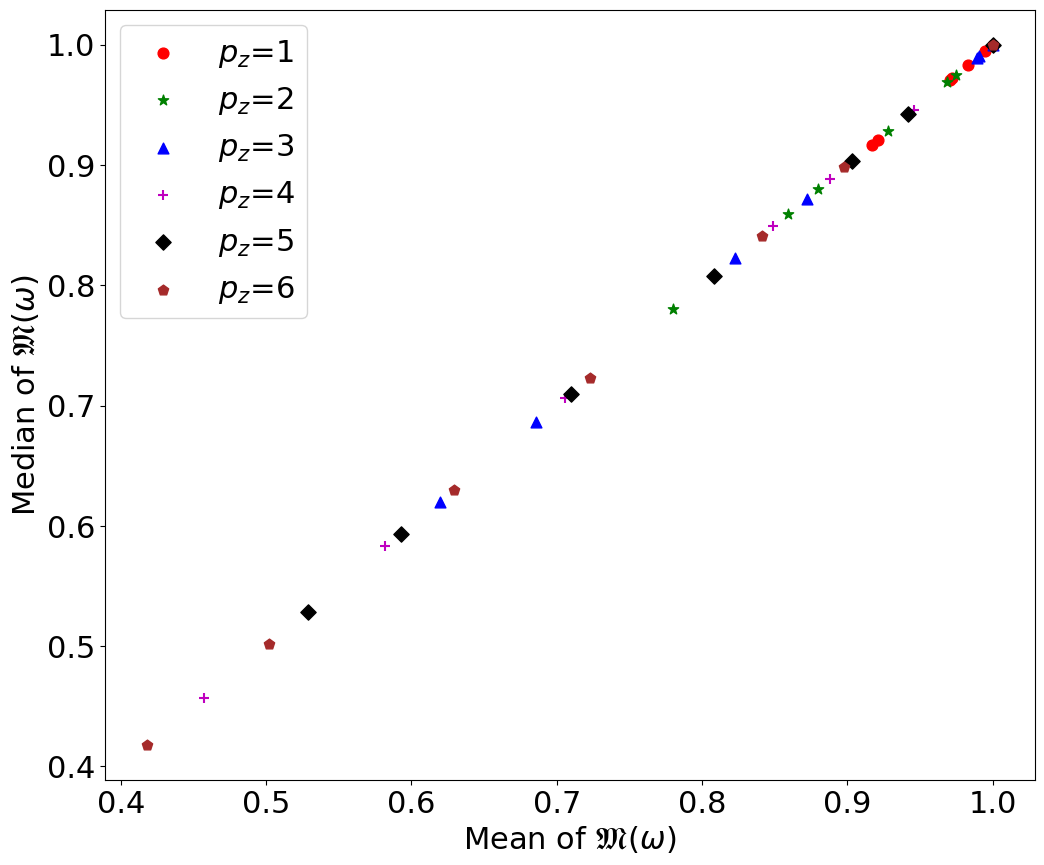

In [5]:
c = ['r','g','b','m','black','brown']
mk = ['o','*','^','+','D','p']

#plt.figure(figsize=(10,10), dpi=300)
for p in df_mms.P.unique():
    tmp = df_mms[df_mms.P==p]
    plt.scatter(tmp.M_mean, tmp.M_med, color=c[p-1], s=60, marker=mk[p-1], label=f"$p_z$={p}")
    
plt.xlabel('Mean of $\mathfrak{M}(\omega)$')    
plt.ylabel('Median of $\mathfrak{M}(\omega)$')
plt.legend()
plt.show()

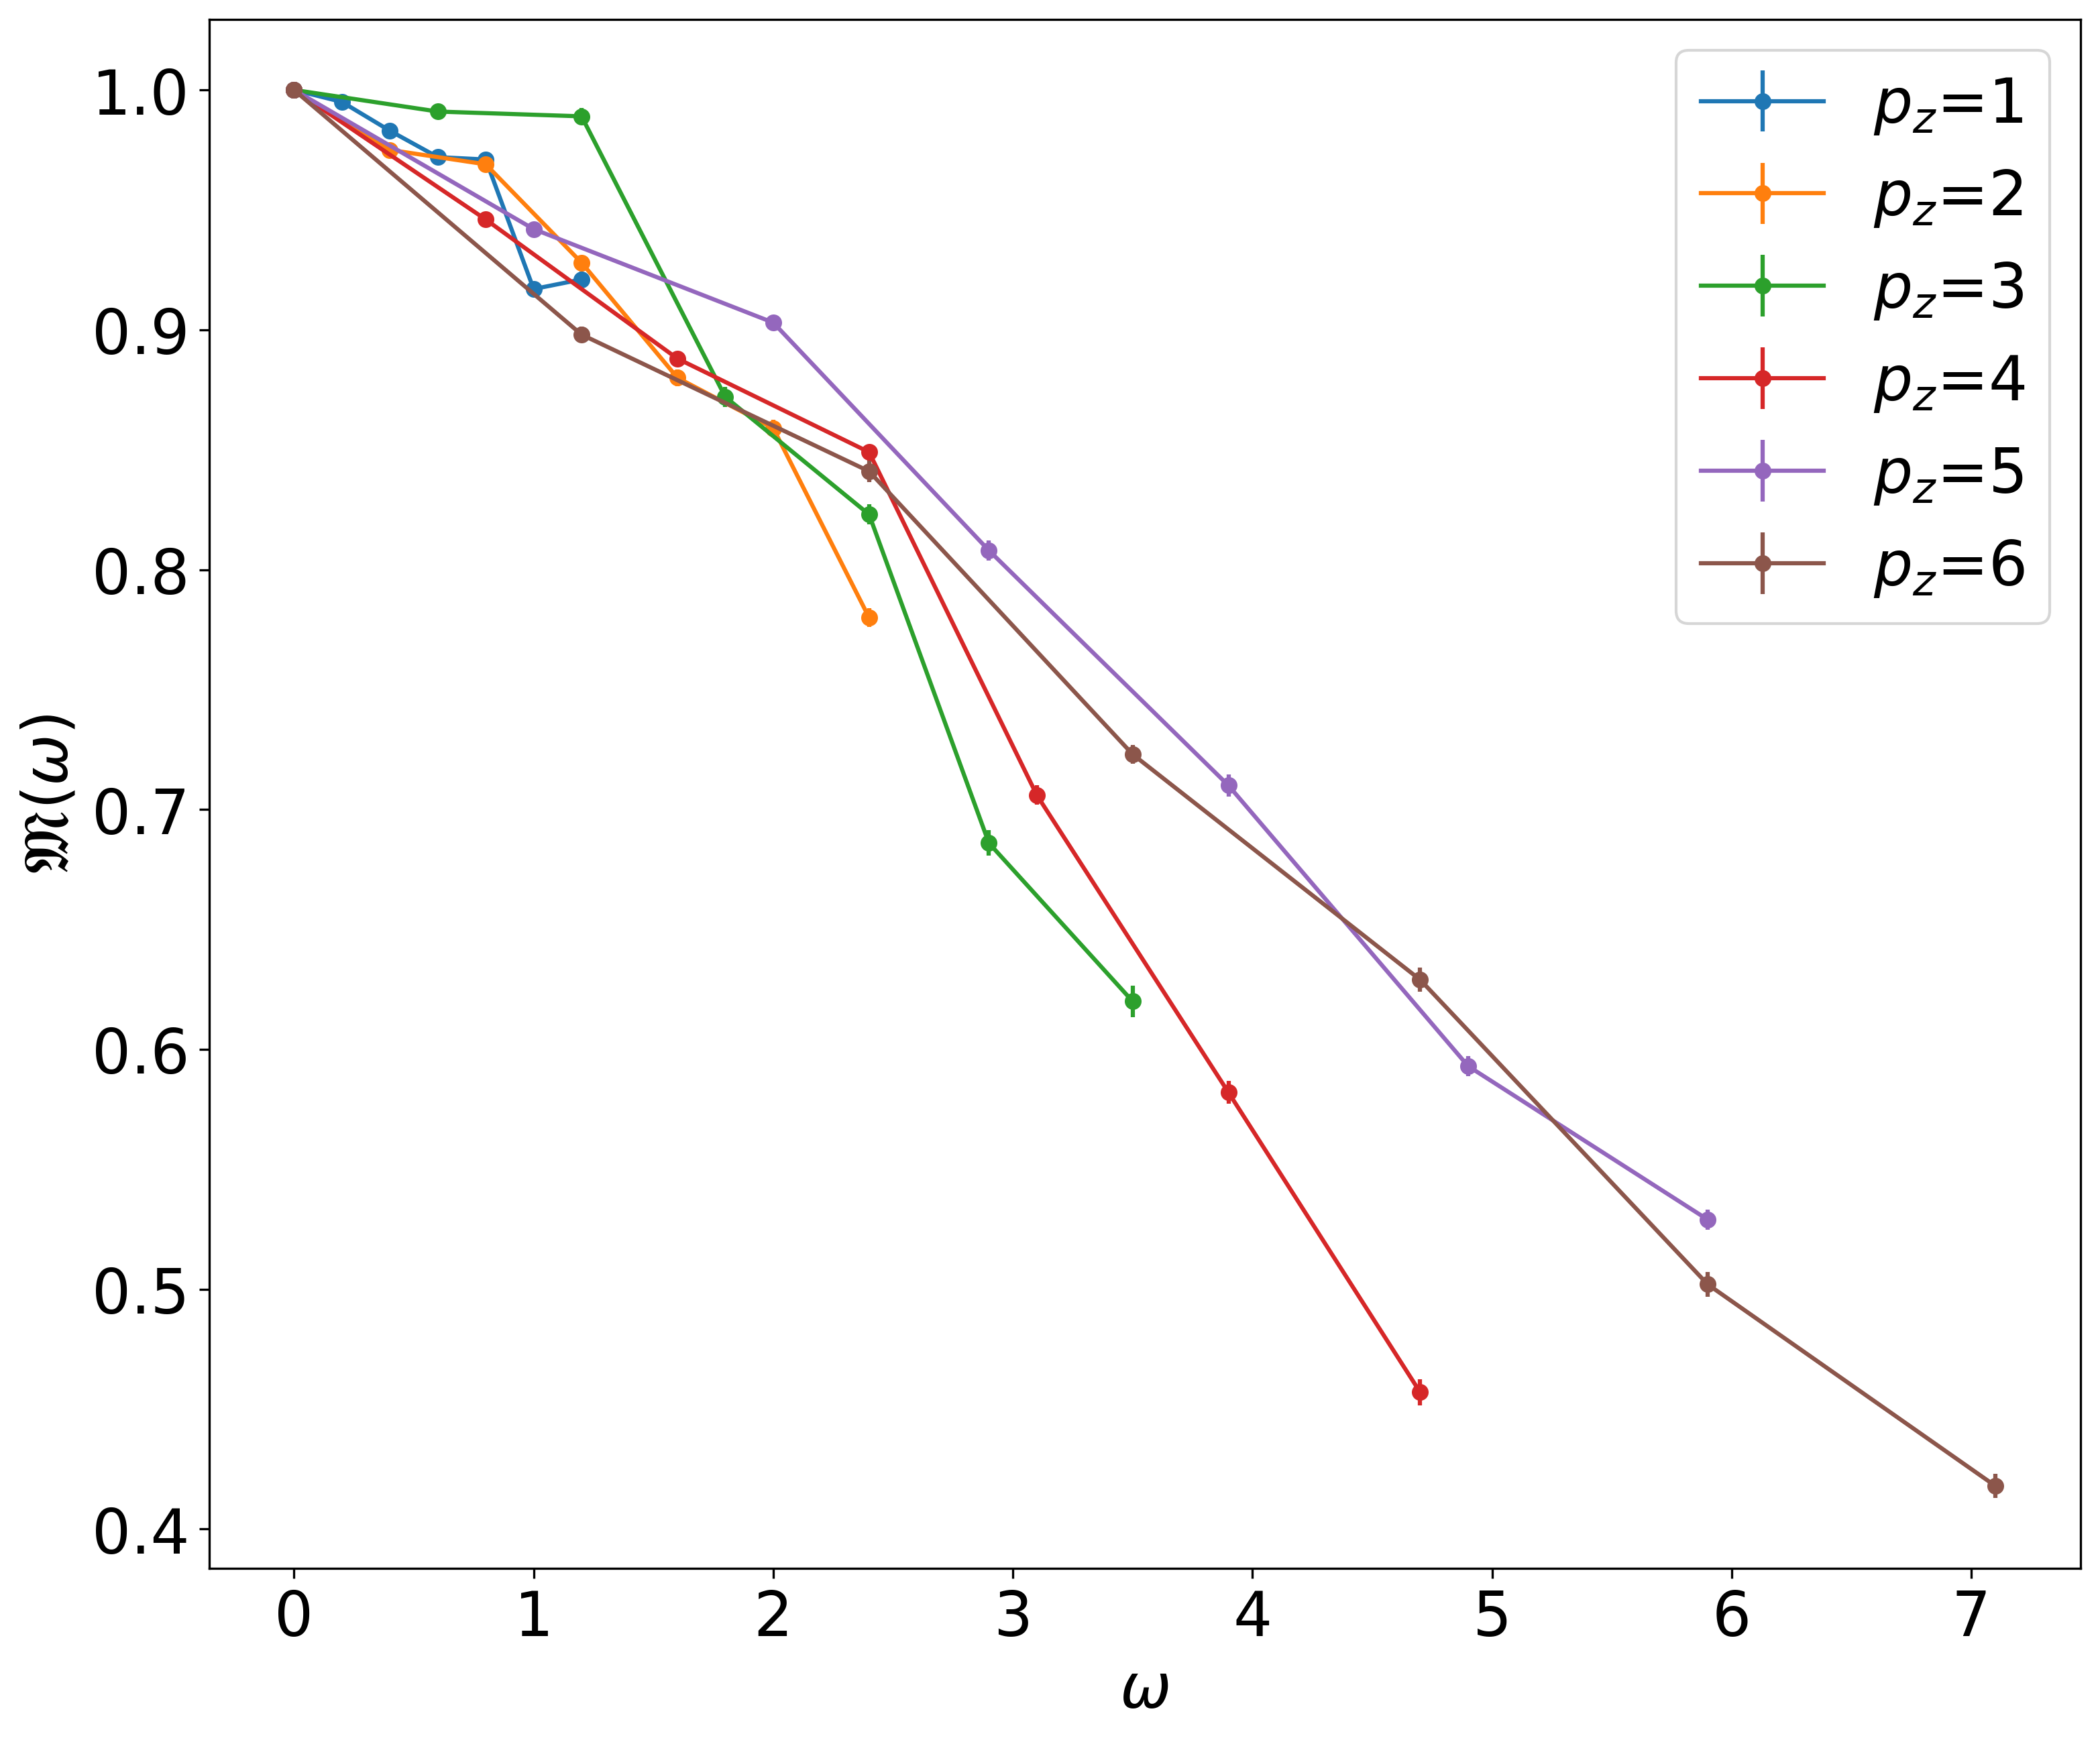

In [6]:
plt.figure(dpi=300)
for p in range(1,7):
    t = df_mms[df_mms.P==p]
    #print(p,t.W.nunique())
    plt.errorbar(x=t.W, y=t.M_mean, yerr=t.M_std, linestyle='-', ms=5, marker='o',  label=f"$p_z$={p}")

plt.xlabel('$\omega$')
plt.ylabel('$\mathfrak{M}(\omega)$')
plt.legend()
plt.show()

## Fitting standard deviation

### Using Linear regression

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

df_real = pd.read_csv('../Data/All_p_w_m.csv')
td = []

for lwi in range(3,8):
    for p in range(1,7):
        w1 = df_real.W[df_real.P==p].unique()
        #print(len(w1))
        list_w, list_std = [],[]
        for w in w1[:lwi]:
            t = df_real[np.logical_and(df_real.W==w, df_real.P==p)]
            list_w.append(w)
            list_std.append(np.std(t.M))

        tmp = pd.DataFrame({'W':list_w, 'S':list_std})
        X = np.array(tmp.W).reshape(-1, 1)
        y = tmp.S.values.ravel()

        bestModel = LinearRegression(fit_intercept=False).fit(X, y)
        pred_std = bestModel.predict(X)

        r2 = r2_score(y, pred_std)
        rms = np.sqrt(mean_squared_error(y, pred_std))
        td.append([p,len(list_w),r2,rms*10**4])
        
td = pd.DataFrame(td, columns=['P','WL','R2','RMS'])
td.to_csv('../Data/RMS.csv', index=False)
td.head()

P  WL        R2       RMS
0  1   3  0.732105  4.347557
1  2   3  0.788318  5.478912
2  3   3  0.846696  6.106658
3  4   3  0.861238  3.642707
4  5   3  0.875398  4.735464

for len(W)=3, avg. RMSE=4.893
for len(W)=4, avg. RMSE=7.137
for len(W)=5, avg. RMSE=7.734
for len(W)=6, avg. RMSE=8.316
for len(W)=7, avg. RMSE=8.706


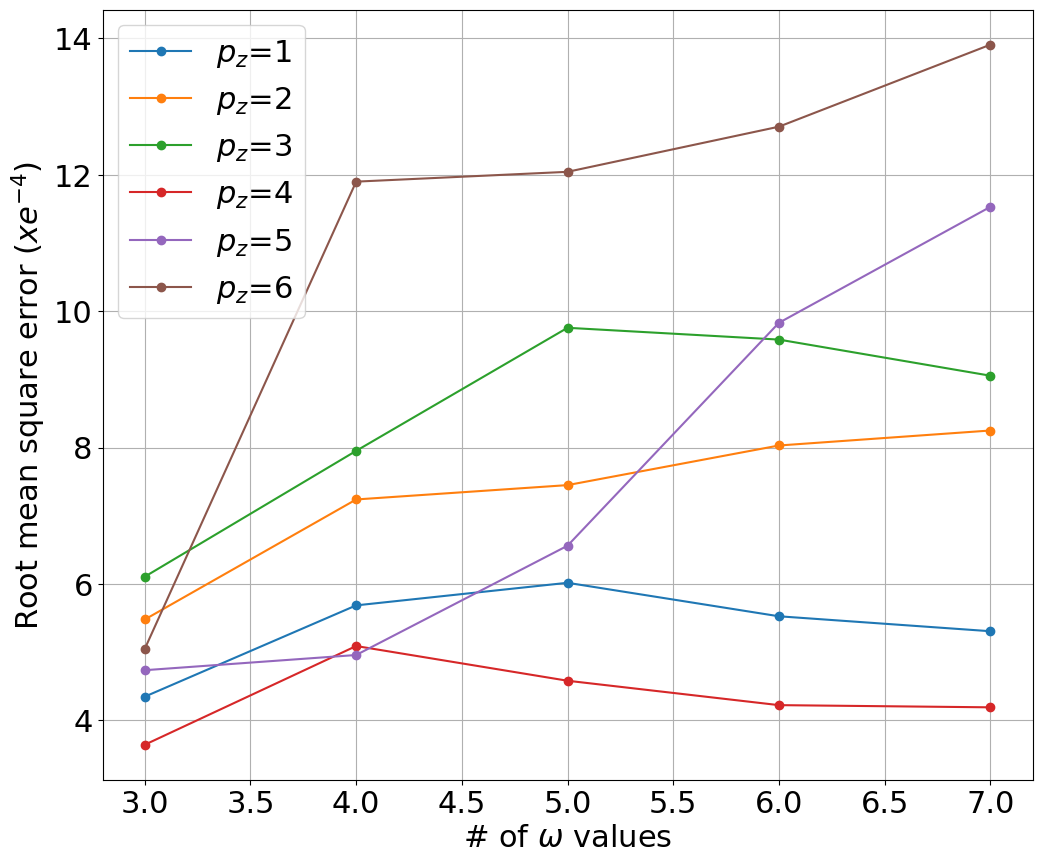

In [8]:
td = pd.read_csv('../Data/RMS.csv')

for w in td.WL.unique():
    t = td[td.WL==w]
    print(f"for len(W)={w}, avg. RMSE={np.mean(t.RMS):.3f}")

for p in range(1,7):
    t = td[td.P==p]
    plt.plot(t.WL, t.RMS, '-o', label=f"$p_z$={p}")
    
plt.xlabel('# of $\omega$ values')
plt.ylabel("Root mean square error ($x e^{-4}$)")
plt.legend()
plt.grid()
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(2,3,dpi=200, figsize=(50,30), layout="constrained", sharey=True)
r,c=0,0
model_LR=[]

for p in range(1,7):
    t = df_mms[df_mms.P==p]
    t.sort_values('W', ascending=True, inplace=True)
    
    tmp = pd.DataFrame({'W':t.W.values, 'S':t.M_std.values})
    X = np.array(tmp.W).reshape(-1, 1)
    y = tmp.S.values.ravel()

    bestModel = LinearRegression(fit_intercept=False,).fit(X, y)
    pred_std = bestModel.predict(X)
    
    ax[r,c].plot(t.W.values, t.M_std.values, '-', label='Real',lw=5,ms=25, marker="^")
    ax[r,c].plot(t.W.values, pred_std, '-', label='Estimated',lw=5,ms=15, marker="o")
    ax[r,c].set_title(f"$p_z$={p}", y=0.98, fontsize=48, pad=-20)
    ax[r,c].set_xticklabels([str(round(x,1)) for x in ax[r,c].get_xticks()], fontsize=38)
    ax[r,c].set_yticklabels(ax[r,c].get_yticks(), fontsize=38)
    #ax[r,c].set_ylim(-0.0001, 0.006)
    ax[r,c].legend(prop={'size':42})
    #ax[r,c].grid()
    
    model_LR.append(bestModel)
    
    if p==1 or p==4:
        ax[r,c].set_ylabel('Std. dev. of $\mathfrak{M}(\omega)$', fontsize=68)
    if p>3:
        ax[r,c].set_xlabel('$\omega$', fontsize=68)

    c+=1
    if p==3:
        r+=1
        c=0

plt.show()

### Fitting standard deviation usign curve fitting

In [10]:
def Y_pred(x, A=1):
    if x<0:
        return 0
    return A*np.sqrt(x)

def fit_curve(w, stdm, init=0.01, lr=0.01, total_epoc=100):
    A = init
    lr = lr
    le = {'epoch':[], 'loss':[]}
    for epoc in range(total_epoc):
        loss = 0
        for x,y in zip(w, stdm):
            loss += (y-Y_pred(x, A))**2
            dl = -2*Y_pred(x)*(y-Y_pred(x, A))
            A = A-(lr*dl)
            
        le['epoch'].append(epoc)
        le['loss'].append(loss)
        
    return np.round(A, 5), pd.DataFrame(le)
    
    
fig, ax = plt.subplots(2,3,dpi=200, figsize=(50,30), layout="constrained", sharey=True)
r,c=0,0
alpha_z = []
for p in range(1,7):
    t = df_mms[df_mms.P==p]
    t.sort_values('W', ascending=True, inplace=True)
    
    A, loss = fit_curve(t.W.values, t.M_std.values, init=0.1, lr=0.01, total_epoc=300)
    print(f"P={p}, A={A}")
    alpha_z.append(A)
    
    ax[r,c].plot(t.W.values, t.M_std.values, '-', label='Real',lw=5,ms=25, marker="^")
    ax[r,c].plot(t.W.values, A*np.sqrt(t.W.values), '-', label='Fitted',lw=5,ms=15, marker="o")
    ax[r,c].set_title(f"$p_z$={p}", fontsize=48, pad=-20, y=0.98)
    ax[r,c].set_xticklabels([str(round(x,1)) for x in ax[r,c].get_xticks()], fontsize=38)
    ax[r,c].set_yticklabels([str(x)[:6] for x in ax[r,c].get_yticks()], fontsize=38)
    #ax[r,c].set_ylim(-0.0001, 0.006)
    ax[r,c].legend(prop={'size':42})
    #ax[r,c].grid()
    
    if p==1 or p==4:
        ax[r,c].set_ylabel('Std. dev. of $\mathfrak{M}(\omega)$', fontsize=68)
    if p>3:
        ax[r,c].set_xlabel('$\omega$', fontsize=68)

    c+=1
    if p==3:
        r+=1
        c=0

plt.show()

P=1, A=0.00274
P=2, A=0.00263
P=3, A=0.00321
P=4, A=0.00226
P=5, A=0.00201
P=6, A=0.00217


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

df_real = pd.read_csv('../Data/All_p_w_m.csv')
td = []
A=[0.00274, 0.00263, 0.00321, 0.00226, 0.00201, 0.00217]

def get_est(x, a):
    return a*np.sqrt(x)

for lwi in range(3,8):
    for p in range(1,7):
        w1 = df_real.W[df_real.P==p].unique()
        #print(len(w1))
        list_std, list_pred = [],[]
        for w in w1[:lwi]:
            t = df_real[np.logical_and(df_real.W==w, df_real.P==p)]
            list_pred.append(get_est(w, A[p-1]))
            list_std.append(np.std(t.M))

        y = np.array(list_std).ravel()
        pred_std = np.array(list_pred).ravel()

        r2 = r2_score(y, pred_std)
        rms = np.sqrt(mean_squared_error(y, pred_std))
        td.append([p,lwi,r2,rms*10**4])
        
td = pd.DataFrame(td, columns=['P','WL','R2','RMS'])
td.to_csv('../Data/RMS.csv', index=False)
td.head()

P  WL        R2       RMS
0  1   3  0.860675  3.135287
1  2   3  0.848974  4.627840
2  3   3  0.964383  2.943443
3  4   3  0.872558  3.490962
4  5   3  0.941138  3.254755

for len(W)=3, avg. RMSE=4.425
for len(W)=4, avg. RMSE=4.794
for len(W)=5, avg. RMSE=4.792
for len(W)=6, avg. RMSE=4.503
for len(W)=7, avg. RMSE=4.557


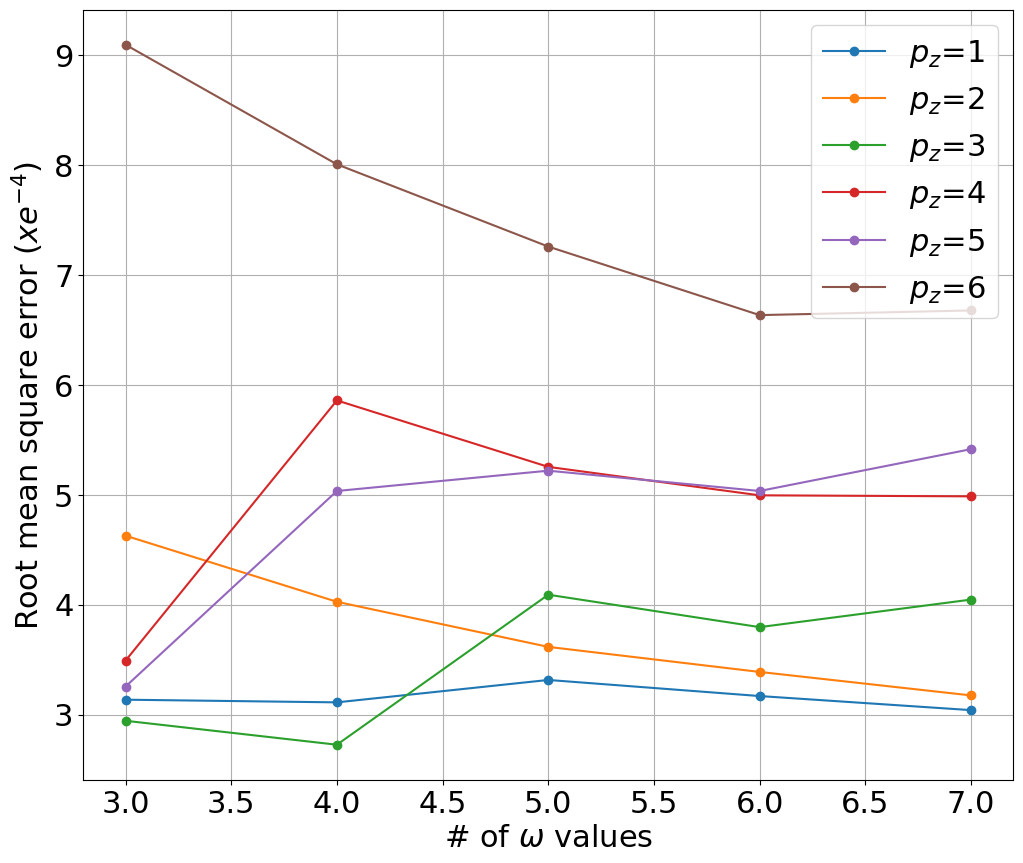

In [12]:
td = pd.read_csv('../Data/RMS.csv')

for w in td.WL.unique():
    t = td[td.WL==w]
    print(f"for len(W)={w}, avg. RMSE={np.mean(t.RMS):.3f}")

for p in range(1,7):
    t = td[td.P==p]
    plt.plot(t.WL, t.RMS, '-o', label=f"$p_z$={p}")
    
plt.xlabel('# of $\omega$ values')
plt.ylabel("Root mean square error ($x e^{-4}$)")
plt.legend()
plt.grid()
plt.show()

## Overlap both real and generated mean

In [13]:
df_est = pd.read_csv('../Data/Fitted_meanM.csv')
df_est.rename(columns={'M':'M_est'}, inplace=True)
df_est.W = np.round(df_est.W, 1)

df_M = df_mms.merge(df_est, on=['P','W'])

fig, ax = plt.subplots(2,3,dpi=200, figsize=(50,30), layout="constrained", sharey=True)
r,c=0,0
cols = ['red','green','blue','brown','magenta','black']
for p in range(1,7):
    tmp = df_M[df_M.P==p]
    ax[r,c].plot(tmp.W, tmp.M_mean, '-', label='Real', lw=5,ms=25, marker="^")
    #plt.plot(tmp.W, tmp.M_mean, '-', label='Real $p_z$={}'.format(p), lw=3, ms=12, color=cols[p-1], marker="^")

    tmp = df_M[df_M.P==p]
    ax[r,c].plot(tmp.W, tmp.M_est, '-', label='Fitted', lw=5,ms=25, marker="o")
    #plt.plot(tmp.W, tmp.M_est, '-', label='Est.  $p_z$={}'.format(p), lw=3, ms=8, color=cols[p-1], marker="o")
    
    #ax[r,c].set_title(f"$p_z$={p}", fontsize=48, pad=-20, )
    ax[r,c].set_xticklabels([str(round(x,1)) for x in ax[r,c].get_xticks()], fontsize=38)
    ax[r,c].set_yticklabels([str(x)[:3] for x in ax[r,c].get_yticks()], fontsize=38)
    #ax[r,c].set_ylim(-0.0001, 0.006)
    
    ax[r,c].set_title(f"$p_z$={p}", fontsize=48, pad=-20, y=0.98)
    ax[r,c].legend(prop={'size':42})
    #ax[r,c].grid()
    
    if p==1 or p==4:
        ax[r,c].set_ylabel('$\mathfrak{M}(\omega)$', fontsize=68)
    if p>3:
        ax[r,c].set_xlabel('$\omega$', fontsize=68)

    c+=1
    if p==3:
        r+=1
        c=0

plt.show()



'''

for p in range(1,7):
    t = df_mms[df_mms.P==p]
    t.sort_values('W', ascending=True, inplace=True)
    
    A, loss = fit_curve(t.W.values, t.M_std.values, init=0.1, lr=0.01, total_epoc=300)
    print(f"P={p}, A={A}")
    
    
    ax[r,c].plot(t.W.values, t.M_std.values, '-', label='Real',lw=5,ms=25, marker="^")
    ax[r,c].plot(t.W.values, A*np.sqrt(t.W.values), '-', label='Estimated',lw=5,ms=15, marker="o")
    ax[r,c].set_title(f"$p_z$={p}", fontsize=48, pad=-20, )
    ax[r,c].set_xticklabels([str(round(x,1)) for x in ax[r,c].get_xticks()], fontsize=38)
    ax[r,c].set_yticklabels([str(x)[:6] for x in ax[r,c].get_yticks()], fontsize=38)
    #ax[r,c].set_ylim(-0.0001, 0.006)
    ax[r,c].legend(prop={'size':42})
    #ax[r,c].grid()
    
    if p==1 or p==4:
        ax[r,c].set_ylabel('Std. dev. of $\Delta\mathfrak{M}(\omega)$', fontsize=68)
    if p>3:
        ax[r,c].set_xlabel('$\omega$', fontsize=68)

    c+=1
    if p==3:
        r+=1
        c=0

plt.show()
'''

'\n\nfor p in range(1,7):\n    t = df_mms[df_mms.P==p]\n    t.sort_values(\'W\', ascending=True, inplace=True)\n    \n    A, loss = fit_curve(t.W.values, t.M_std.values, init=0.1, lr=0.01, total_epoc=300)\n    print(f"P={p}, A={A}")\n    \n    \n    ax[r,c].plot(t.W.values, t.M_std.values, \'-\', label=\'Real\',lw=5,ms=25, marker="^")\n    ax[r,c].plot(t.W.values, A*np.sqrt(t.W.values), \'-\', label=\'Estimated\',lw=5,ms=15, marker="o")\n    ax[r,c].set_title(f"$p_z$={p}", fontsize=48, pad=-20, )\n    ax[r,c].set_xticklabels([str(round(x,1)) for x in ax[r,c].get_xticks()], fontsize=38)\n    ax[r,c].set_yticklabels([str(x)[:6] for x in ax[r,c].get_yticks()], fontsize=38)\n    #ax[r,c].set_ylim(-0.0001, 0.006)\n    ax[r,c].legend(prop={\'size\':42})\n    #ax[r,c].grid()\n    \n    if p==1 or p==4:\n        ax[r,c].set_ylabel(\'Std. dev. of $\\Delta\\mathfrak{M}(\\omega)$\', fontsize=68)\n    if p>3:\n        ax[r,c].set_xlabel(\'$\\omega$\', fontsize=68)\n\n    c+=1\n    if p==3:\n      

In [14]:
df_mms.head()

P    W  M_mean  M_med   M_std
0  1  0.0   1.000  1.000  0.0000
1  1  0.2   0.995  0.995  0.0017
2  1  0.4   0.983  0.983  0.0018
3  1  0.6   0.972  0.972  0.0018
4  1  0.8   0.971  0.971  0.0020

## Compute Standard deviation for all P's

In [15]:
df_fit = pd.read_csv('../Data/Fitted_meanM_stdM.csv')
df_fit.head()

P    W     M_fit     S_fit
0  1  0.0  1.000000  0.000000
1  1  0.1  0.997182  0.000866
2  1  0.2  0.992651  0.001224
3  1  0.3  0.987162  0.001499
4  1  0.4  0.980972  0.001731

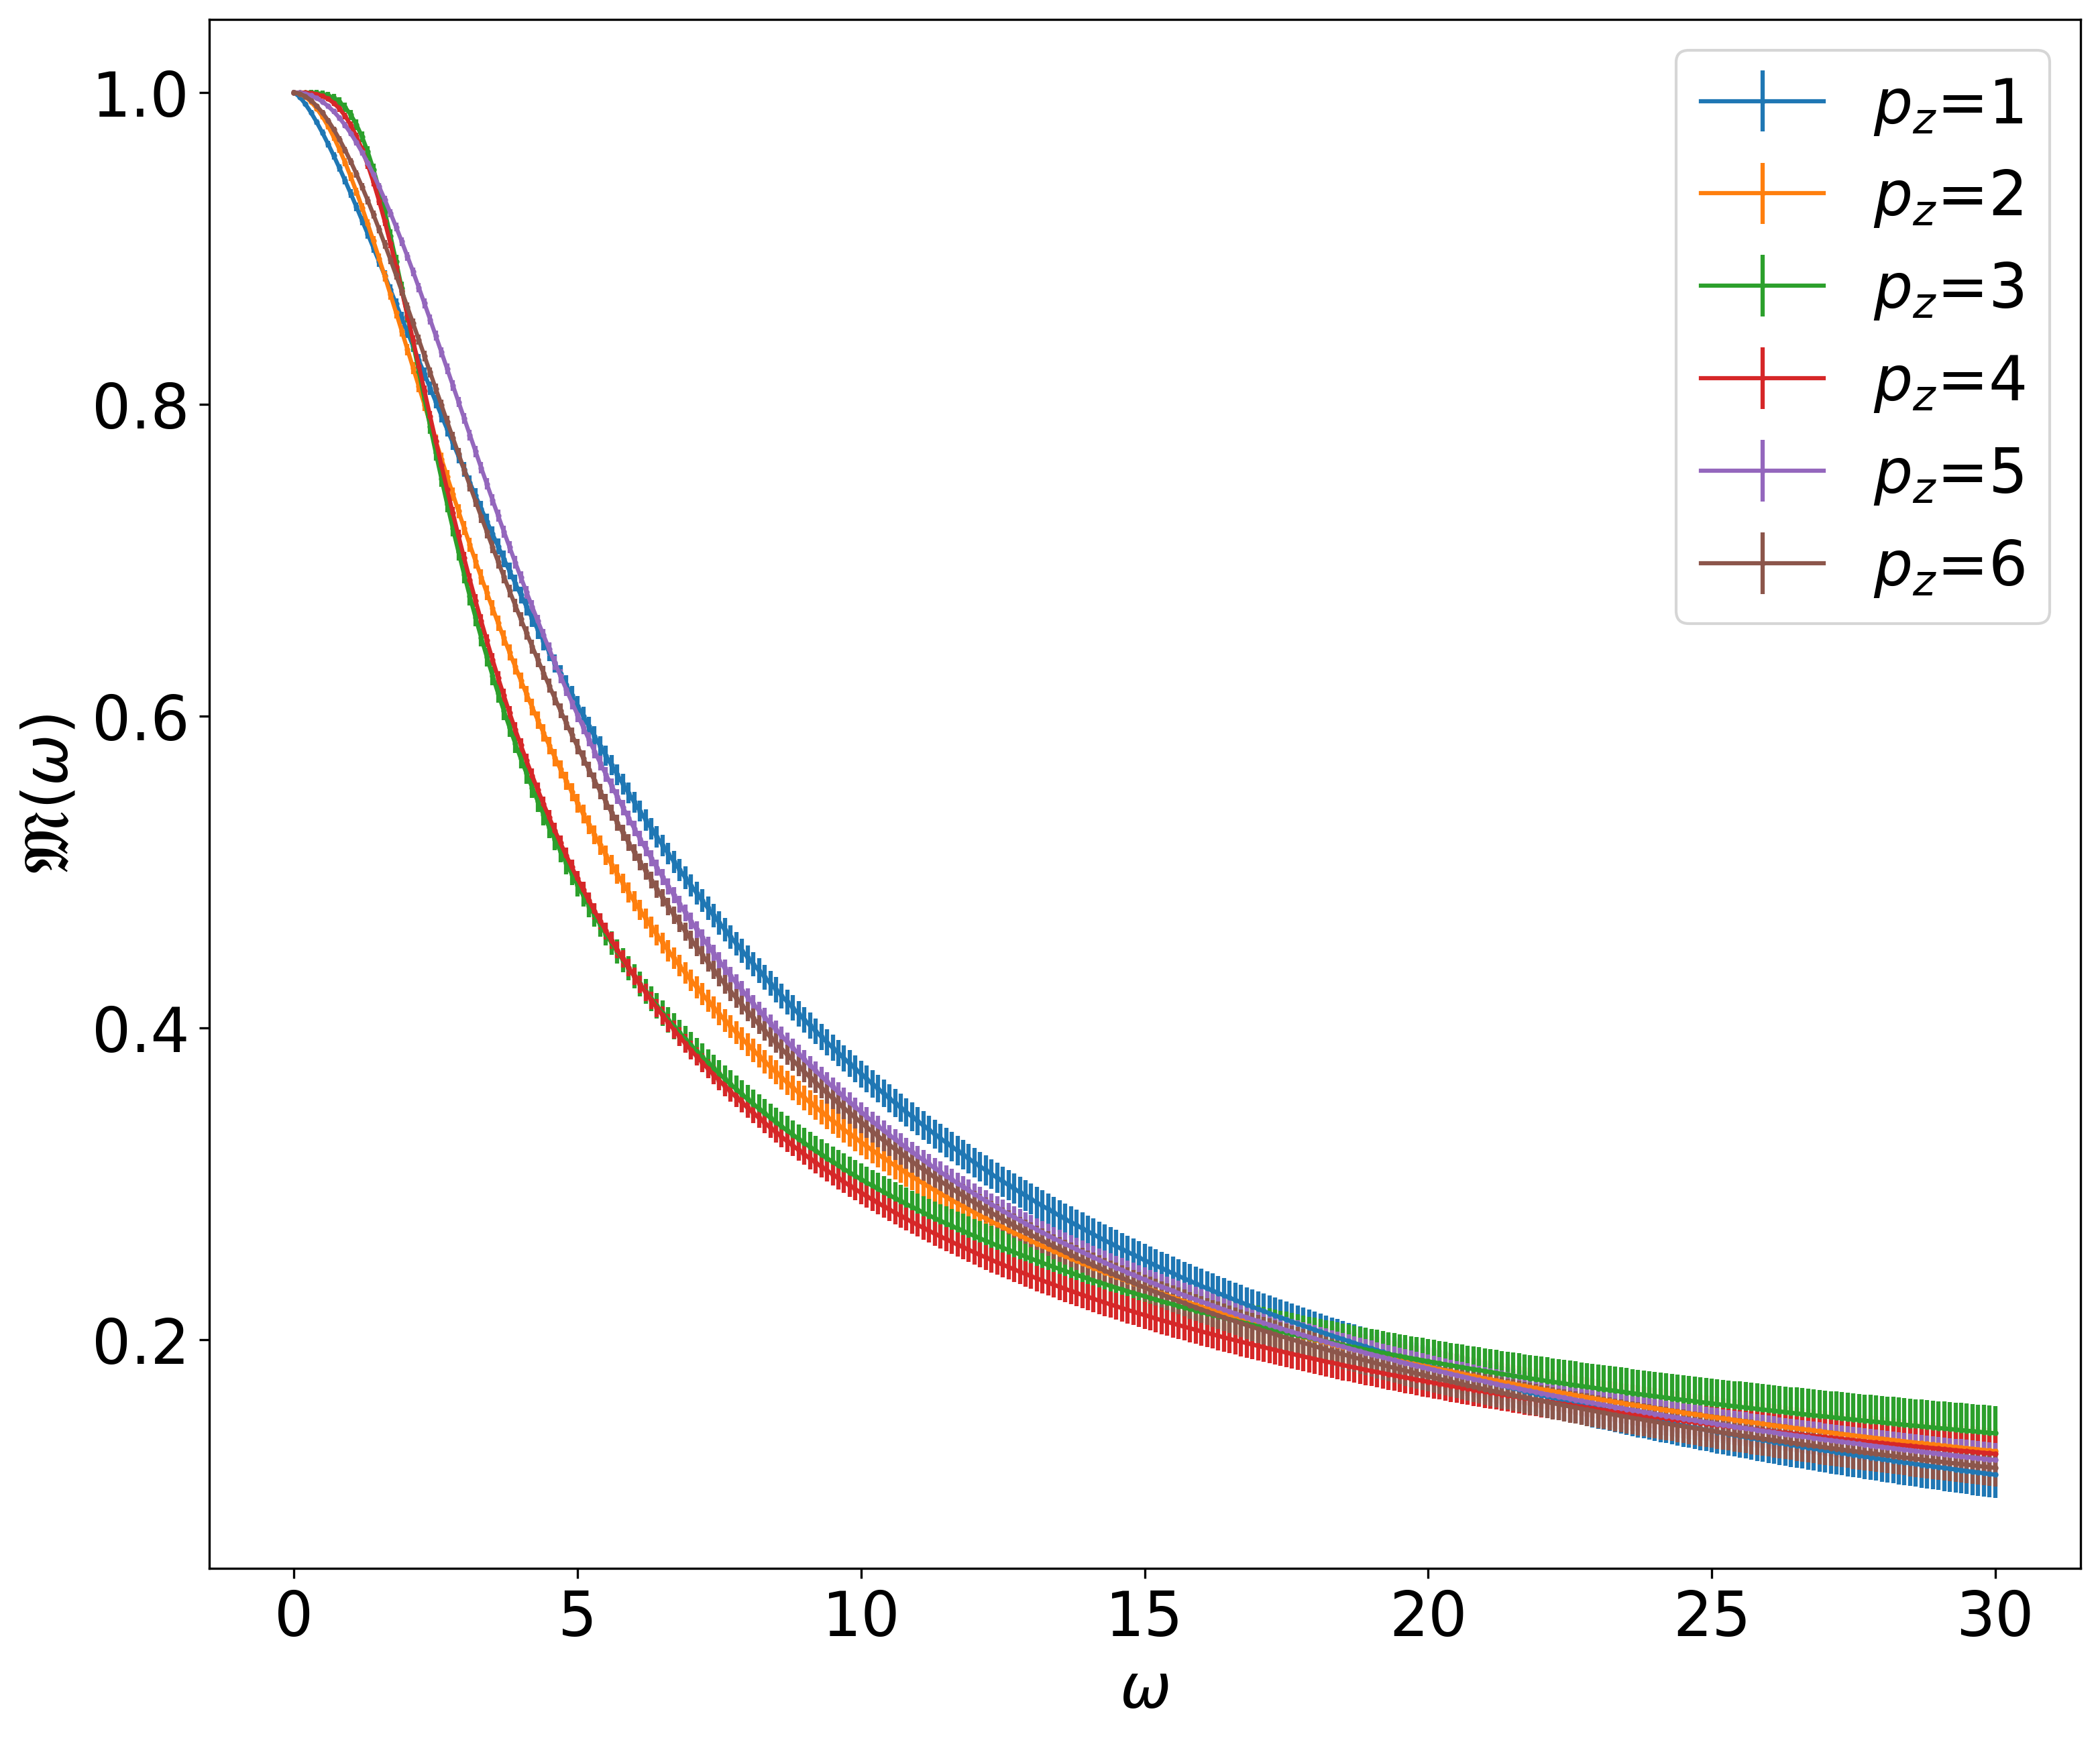

In [16]:
plt.figure(dpi=300)
for p in range(1,7):
    t = df_fit[df_fit.P==p]
    #print(p,t.W.nunique())
    plt.errorbar(x=t.W, y=t.M_fit, yerr=t.S_fit, linestyle='-', ms=1, marker='o',  label=f"$p_z$={p}")

plt.xlabel('$\omega$')
plt.ylabel('$\mathfrak{M}(\omega)$')
plt.legend()
plt.show()

## Generate synthetic data using normal distribution

In [ ]:
cols = []
for i in range(1, 352):
    c = 'E{}'.format(i)
    cols.append(c)
    df_fit.loc[:,c] = df_fit.M_fit
    
df_fit.head()

In [ ]:
df_data = df_fit.melt(id_vars=['P','W','M_fit','S_fit'], value_vars=cols, value_name='expM', var_name='Exp')
df_data.Exp = [int(x[1:]) for x in df_data.Exp]
df_data.head()

In [ ]:
from numpy.random import seed
from numpy.random import normal

for p in df_data.P.unique():
    seed(p)
    
    for w in sorted(df_data.W[df_data.P==p].unique()):
        t = df_data.loc[np.logical_and(df_data.W==w, df_data.P==p), ['M_fit', 'S_fit']].drop_duplicates()
        mu = t.M_fit.values[0]
        sigma = t.S_fit.values[0]

        #generate sample of 200 values that follow a normal distribution 
        #expData = normal(loc=mu, scale=sigma, size=1901)
        df_data.loc[np.logical_and(df_data.W==w, df_data.P==p), 'expM'] = sorted(normal(loc=mu, scale=sigma, size=351))
        #if len(set(expData)) != 1901:
        #    print(p, w, mu, sigma, len(expData), len(set(expData)))
        
df_data.head()

In [ ]:
df_data[['P','W','Exp','expM']].drop_duplicates().to_csv('../Data/Fitted_all_exp.csv', index=False)

In [ ]:
fig, ax = plt.subplots(3,2,sharex=True, figsize=(25,30))

for p in range(1,7):
    i,j = (p-1)//2, (p-1)%2
    tmp = df_data[np.logical_and(df_data.P==p, True)]
    tmp.sort_values('W', inplace=True)
    ax[i,j].plot(tmp.W, tmp.expM, '-o')
    ax[i,j].set_title('p={}'.format(p))
    
plt.show()

In [17]:
df_data = pd.read_csv('../Data/Fitted_all_exp.csv')
df_data.head()

P    W  Exp      expM
0  1  0.0    1  1.000000
1  1  0.1    1  0.994767
2  1  0.2    1  0.988913
3  1  0.3    1  0.983263
4  1  0.4    1  0.975513

In [18]:
df_avg = df_data.groupby(['P','W'])['expM'].apply(lambda x: np.average(x)).reset_index()
df_avg.columns = ['P','W','mean_M']

df_std = df_data.groupby(['P','W'])['expM'].apply(lambda x: np.std(x)).reset_index()
df_std.columns = ['P','W','std_M']

df_g = df_avg.merge(df_std, on=['P','W'])
df_g.head()

P    W    mean_M     std_M
0  1  0.0  1.000000  0.000000
1  1  0.1  0.997213  0.000881
2  1  0.2  0.992647  0.001199
3  1  0.3  0.987279  0.001442
4  1  0.4  0.980980  0.001936

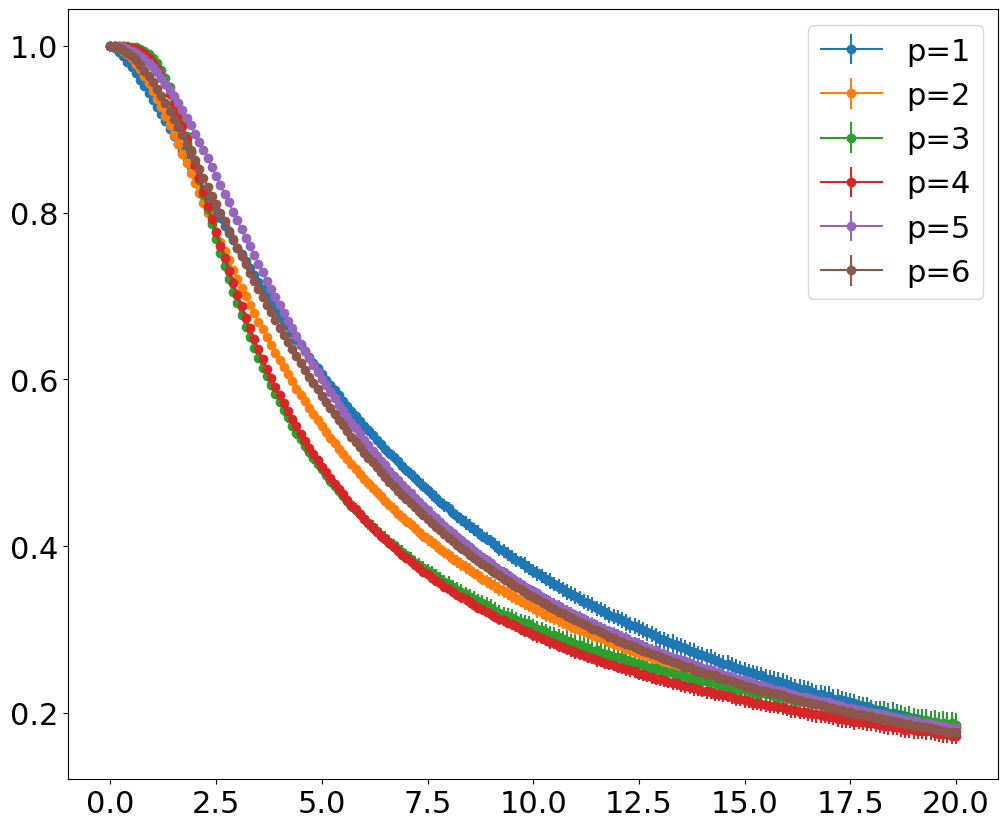

In [19]:
for p in range(1,7):
    tmp = df_g[np.logical_and(df_g.P==p, df_g.W<=20)]
    #plt.plot(tmp.W, tmp.mean_M, label='p={}'.format(p))
    plt.errorbar(tmp.W, tmp.mean_M,yerr=tmp.std_M,fmt='-o', label='p={}'.format(p))
    
    
plt.legend(loc='best')
plt.show()

In [20]:
df_real = pd.read_csv('../Data/All_p_w_m.csv')
df_avg = df_real.groupby(['P','W'])['M'].apply(lambda x: np.average(x)).reset_index()
df_avg.columns = ['P','W','mean_M']

df_std = df_real.groupby(['P','W'])['M'].apply(lambda x: np.std(x)).reset_index()
df_std.columns = ['P','W','std_M']

df_gr = df_avg.merge(df_std, on=['P','W'])
df_gr.head()

P        W    mean_M     std_M
0  1  0.00000  1.000000  0.000000
1  1  0.19635  0.995113  0.001749
2  1  0.39270  0.983199  0.001813
3  1  0.58905  0.972003  0.001799
4  1  0.78540  0.971211  0.002025

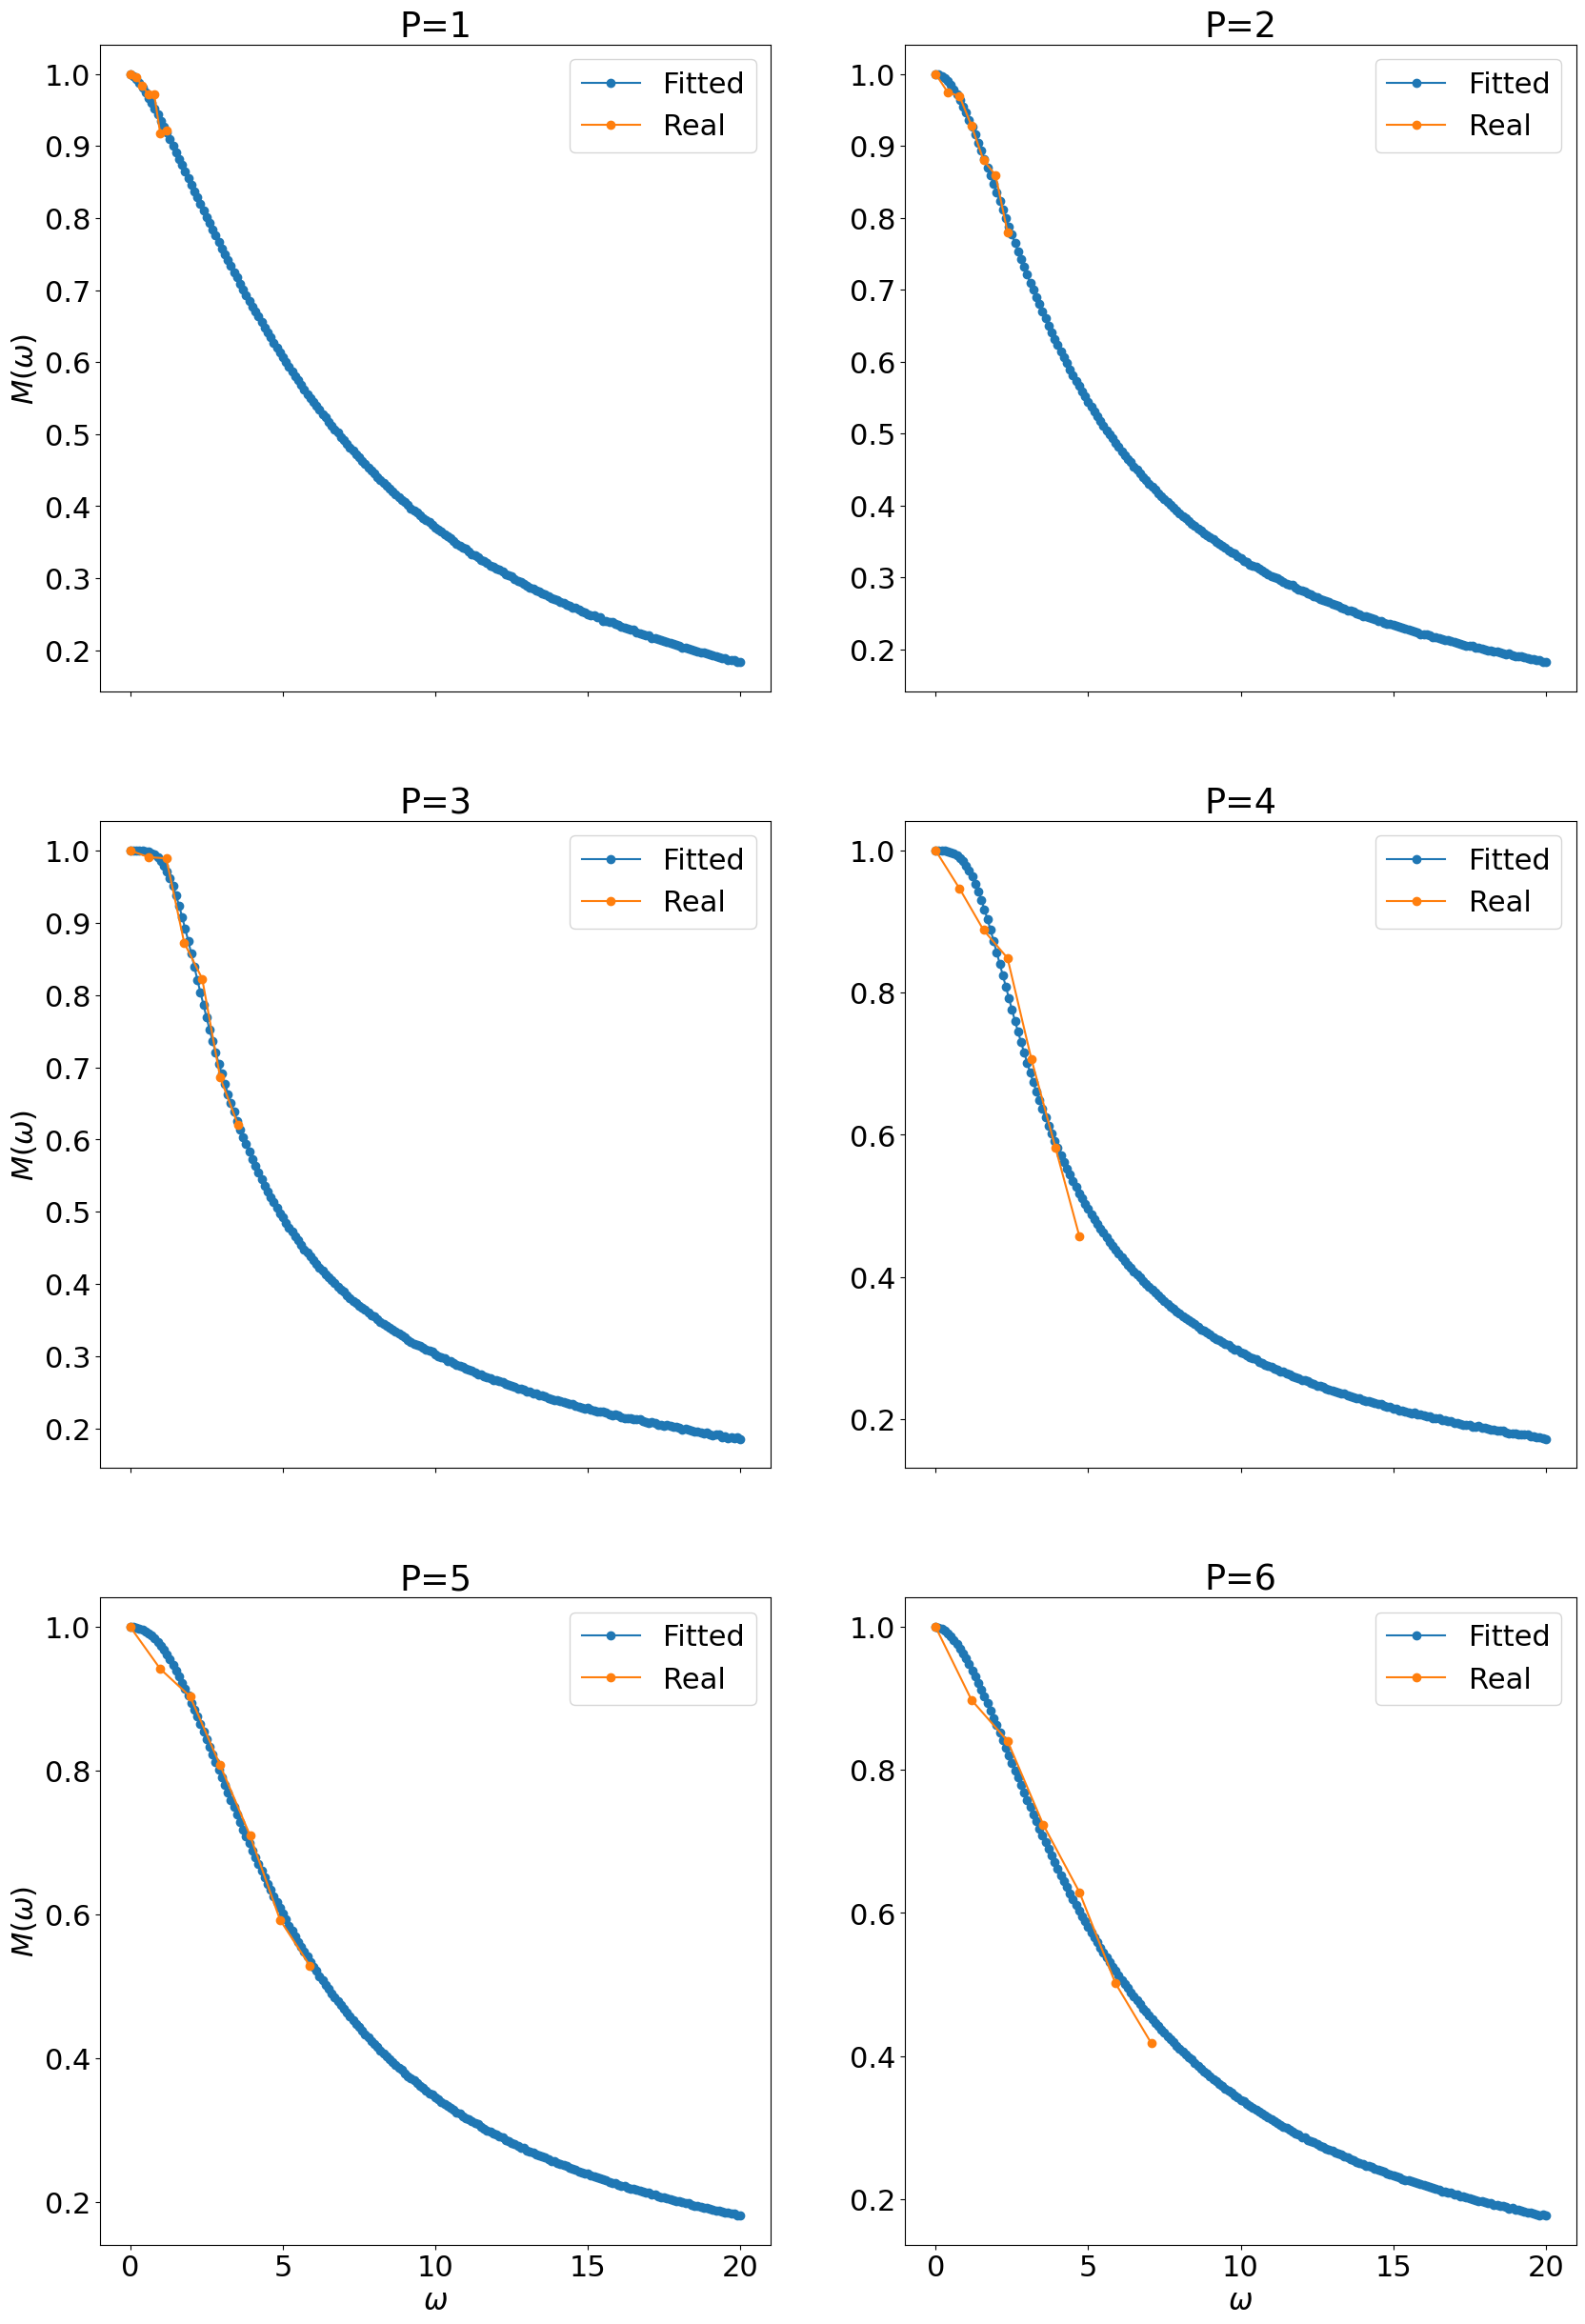

In [21]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(20,30))
for p in range(1,7):
    axs[(p-1)//2,(p-1)%2].plot(df_g.W[np.logical_and(df_g.P==p, df_g.W<=20)], df_g.mean_M[np.logical_and(df_g.P==p, df_g.W<=20)], '-o', label='Fitted')
    axs[(p-1)//2,(p-1)%2].plot(df_gr.W[df_gr.P==p], df_gr.mean_M[df_gr.P==p], '-o', label='Real')
    
    axs[(p-1)//2,(p-1)%2].set_title('P={}'.format(p))

    if (p-1)//2==2:
        axs[(p-1)//2,(p-1)%2].set(xlabel='$\omega$')

    if (p-1)%2==0:
        axs[(p-1)//2,(p-1)%2].set(ylabel='$M(\omega)$')
    
    axs[(p-1)//2,(p-1)%2].legend(loc='best')
    
plt.show()

In [ ]:
for p in df_real.P.unique():
    print(p, df_real[df_real.P==p].W.nunique())